In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from utils import *
import re
import gensim
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/adamblock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/adamblock/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/adamblock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Getting Words Associated to Topics

In [3]:
nmf = load("./models/NMF_all_10_topics.joblib")
tfidf_vectorizer = load("./models/tfidf_vectorizer.joblib")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [4]:
number_of_words = 10
display_topics(nmf, tfidf_feature_names,number_of_words)

Topic 0:
new year one time right well back much next last
Topic 1:
gas greenhouse emission cut growing fuel reduce potential keep half
Topic 2:
going get touched everywhere pot impacted specie melting go youre
Topic 3:
president trump obama said house donald white paris administration hoax
Topic 4:
talk scientist sensor road tree network car internet everything call
Topic 5:
issue care health like republican immigration democrat important gun reform
Topic 6:
think he would going well something lot there really important
Topic 7:
world state country united america nation threat make facing leader
Topic 8:
people want american lot like thing get job young tax
Topic 9:
believe know science real scientist said human doesnt question man


# 1) Getting and Preprocessing Data

In [4]:
PARENT = "../TelevisionNews/"

In [5]:
cnn, fox, msnbc = get_data(PARENT)

In [6]:
cnn["cleanSnip"] = cnn["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))
fox["cleanSnip"] = fox["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))
msnbc["cleanSnip"] = msnbc["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))

In [7]:
all_shows = pd.concat([cnn,fox,msnbc])

# 2)  Model Selection with `gensim`

In [60]:
corpus = list(all_shows["cleanSnip"])

In [62]:
dictionary = gensim.corpora.Dictionary(corpus)

In [65]:
common_corpus = [dictionary.doc2bow(text) for text in corpus]

## Training NMF models

In [89]:
cm = CoherenceModel(model=nmf, texts=all_shows["cleanSnip"], coherence='c_v')
coherence = cm.get_coherence()

In [91]:
topic_range = range(5,17)
nmf_models = []
for k in topic_range:
    print(f"Working on k = {k}")
    model = Nmf(common_corpus, num_topics=k, id2word=dictionary)
    nmf_models.append(model)

Working on k = 5
Working on k = 6
Working on k = 7
Working on k = 8
Working on k = 9
Working on k = 10
Working on k = 11
Working on k = 12
Working on k = 13
Working on k = 14
Working on k = 15
Working on k = 16


## Getting Coherences

In [143]:
coherence_models = []
coherences = []
for k in topic_range:
    print(f"Working on k = {k}")
    coherence_model = CoherenceModel(model=nmf_models[k -5], texts=all_shows["cleanSnip"], coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_models.append(coherence_model)
    coherences.append(coherence)
    

Working on k = 5
Working on k = 6
Working on k = 7
Working on k = 8
Working on k = 9
Working on k = 10
Working on k = 11
Working on k = 12
Working on k = 13
Working on k = 14
Working on k = 15
Working on k = 16


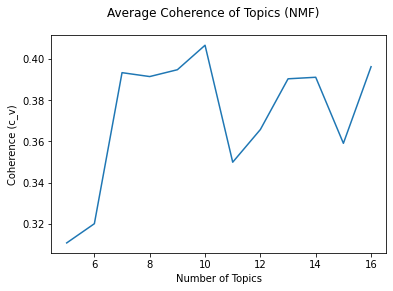

In [151]:
fig, ax = plt.subplots()
ax.plot(topic_range, coherences)
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence (c_v)")
fig.suptitle("Average Coherence of Topics (NMF)")
fig.savefig("./plots/Coherences.png")
plt.show()


## Showing Topic words with `gensim`

In [135]:
def get_words(topic):
    words = []
    i = 0
    while i < len(topic):
        char = topic[i]

        if char == "*":
            i += 2
            word = ""
            char = topic[i]
            while char.isalpha():
                word += char
                i += 1
                char = topic[i]
            words += [word]
            i+=1
        else:
            i += 1
        
    return words
                

In [141]:
def show_topic(model, num_words):
    i = 0
    for _, topic in model.show_topics(0,num_words):
        words = get_words(topic)
        out = f"Topic {i}:\t"
        for word in words:
            out += word + ", "
        print(out)
        i+= 1

# 3) Topic Mentions over Time

Different format for `cleanSnip` needed for `sklearn`:

In [25]:
def topic_words(model, names, no_top_words=5):
    relevant_words = dict()
    for topic_idx, topic in enumerate(model.components_):
        relevant_words[topic_idx] = {names[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
    return relevant_words


In [29]:
def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [54]:
def topic_mentions(snip, topic, model=nmf, names=tfidf_feature_names, no_top_words=5):
    relevant_words = topic_words(model, names, no_top_words)[topic]
    count = 0
    snippet = snip.split(" ")
    for word in relevant_words:
        count += snippet.count(word)
    return count
    

In [12]:
cnn["cleanSnip"] = cnn["Snippet"].apply(lambda x: preprocessing(x, stop_words,True))
fox["cleanSnip"] = fox["Snippet"].apply(lambda x: preprocessing(x, stop_words,True))
msnbc["cleanSnip"] = msnbc["Snippet"].apply(lambda x: preprocessing(x, stop_words,True))
all_shows = pd.concat([cnn,fox,msnbc])

In [15]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
# tfidf = tfidf_vectorizer.fit_transform(all_shows['cleanSnip'])
# dump(tfidf_vectorizer, "./models/tfidf_vectorizer.joblib")

In [137]:
tfidf_vectorizer = load("./models/tfidf_vectorizer.joblib")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [16]:
NUM_TOPICS = 10

In [17]:
# nmf = NMF(n_components=NUM_TOPICS).fit(tfidf)
# dump(nmf, f"./models/NMF_all_{NUM_TOPICS}_topics.joblib")

In [18]:
nmf = load("./models/NMF_all_10_topics.joblib")

In [19]:
display_topics(nmf, tfidf_feature_names,10)

Topic 0:
new year one time right well back much next last
Topic 1:
gas greenhouse emission cut growing fuel reduce potential keep half
Topic 2:
going get touched everywhere pot impacted specie melting go youre
Topic 3:
president trump obama said house donald white paris administration hoax
Topic 4:
talk scientist sensor road tree network car internet everything call
Topic 5:
issue care health like republican immigration democrat important gun reform
Topic 6:
think he would going well something lot there really important
Topic 7:
world state country united america nation threat make facing leader
Topic 8:
people want american lot like thing get job young tax
Topic 9:
believe know science real scientist said human doesnt question man


## By Month

In [81]:
def get_topic_counts(cache, channel, idx, freq='M'):
    temp = channel.copy()
    temp.set_index("DateTime", inplace=True)
    temp = temp[["cleanSnip"]]
    temp = temp.groupby(pd.Grouper(freq=freq)).sum()
    temp = temp.loc[temp["cleanSnip"] != 0]
    for topic in range(NUM_TOPICS):
        temp[str(topic)] = temp["cleanSnip"].apply(lambda x:topic_mentions(x,topic))
    temp.drop("cleanSnip", axis=1, inplace=True)
    cache[idx] = temp

In [82]:
by_month = dict()
get_topic_counts(by_month, cnn, "cnn")
get_topic_counts(by_month, fox, "fox")
get_topic_counts(by_month, msnbc, "msnbc")

### Plotting

In [133]:
def plot_mentions_channel(channel, topics=range(NUM_TOPICS), save=True):
    fig, ax = plt.subplots()
    for k in topics:
        ax.plot(by_month[channel][str(k)], alpha=.6)

    ax.set_xlabel("Date")
    ax.set_ylabel("Topic Mentions")
    fig.suptitle("Topic Mentions by Month: " + channel.upper())
    if save:
        path = "./plots/" + channel + "_Monthly_Mentions.png"
        fig.savefig(path)
    plt.show()

In [134]:
def plot_mentions_topic(topic, channels=["cnn", "fox", "msnbc"], save=True):
    fig, ax = plt.subplots()
    for channel in channels:
        ax.plot(by_month[channel][str(topic)], alpha=.6, label=channel.upper())
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Topic Mentions")
    if save:
        path = "./plots/" + str(topic) + "_Monthly_Mentions.png"
        fig.savefig(path)
    fig.suptitle("Mentions of Topic " + str(topic) + " by Month ")

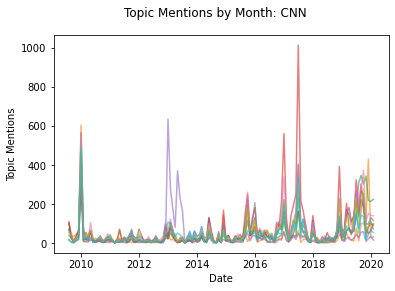

In [135]:
plot_mentions_channel("cnn")

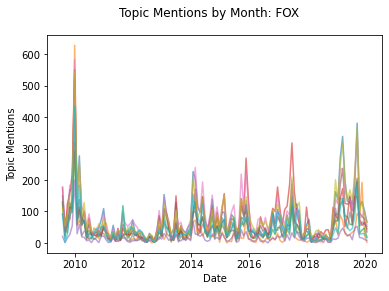

In [131]:
plot_mentions_channel("fox")

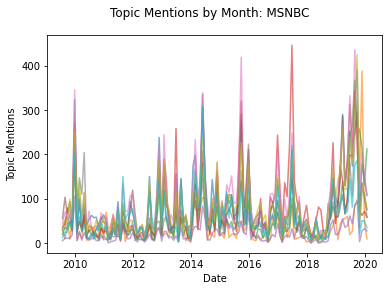

In [132]:
plot_mentions_channel("msnbc")

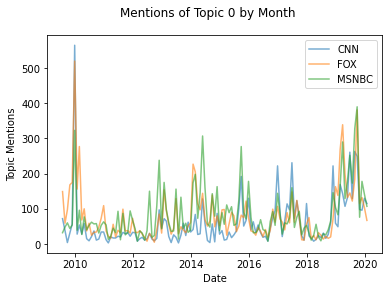

In [117]:
plot_mentions_topic(0)

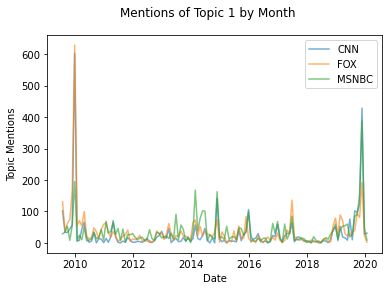

In [118]:
plot_mentions_topic(1)

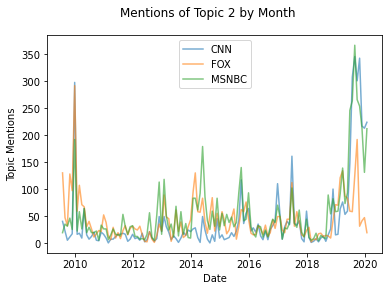

In [119]:
plot_mentions_topic(2)

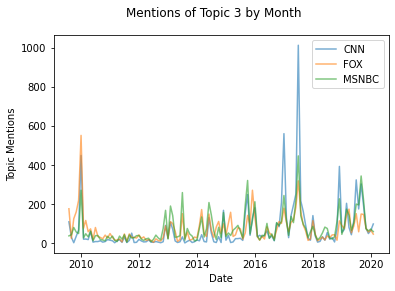

In [120]:
plot_mentions_topic(3)

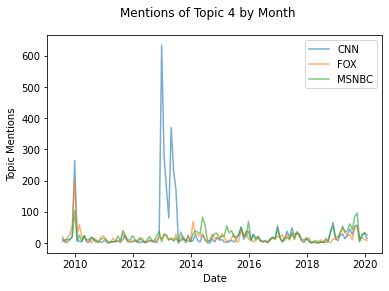

In [121]:
plot_mentions_topic(4)

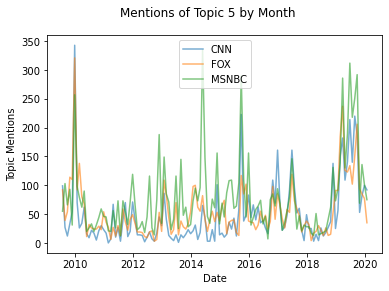

In [122]:
plot_mentions_topic(5)

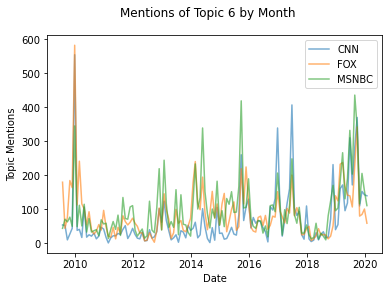

In [123]:
plot_mentions_topic(6)

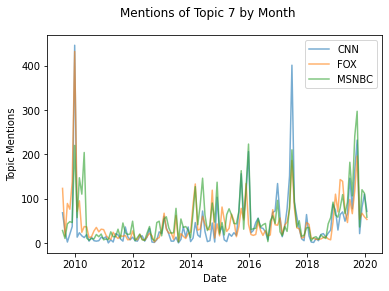

In [124]:
plot_mentions_topic(7)

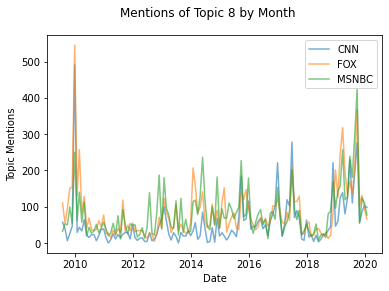

In [125]:
plot_mentions_topic(8)

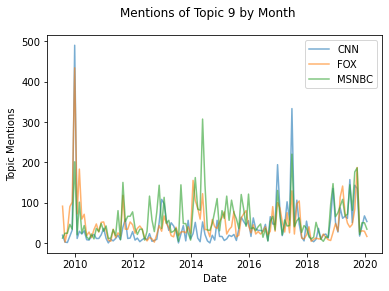

In [126]:
plot_mentions_topic(9)